# Applying prophet to time series forecasting of Well and Riser flow rates

## Author: Ridha Alkhabaz

This is notebook to explore Prophet algorithm viability to predict mass flow rates in a off-shore riser. Specifically, we are investigating gas mass flow rate in this notebook. 


## Imports:

In [ ]:
import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, dates
from prophet import Prophet
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import datetime as dttm
os.chdir('/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML/src')
from preprocessing import read_data_slugging
os.chdir('/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML')
from main import model_init, model_train, model_predict 

#### Reading the data and visualization:

Our split here is to use the previous 10 periods to predict the last period. 

In [ ]:
df,data_slugging,headers, _= read_data_slugging('riser_pq_uni.csv', plot_data=True)

In [ ]:
### univariate prophet 
train_uni = pd.concat([df.iloc[:2806, 0], df.iloc[:2806, 8:]], axis=1)
test_uni = pd.concat([df.iloc[2806:, 0], df.iloc[2806:len(df), 8:]], axis=1)
### multivariate prophet 
train_mult = df.iloc[:2806]
test_mult = df.iloc[2806:len(df)]

#### Initialization:
We are trying to find the difference between univariate, multivairate, tuned and basic implementation of Prophet. 

In [ ]:
prop_gas_uni_basic = model_init(model='Prophet', params=[], hyperparamters=[])
prop_gas_uni_tuned = model_init(model='Prophet', params=[], hyperparamters=[{'daily_seasonality':True,'holidays_prior_scale':0.01, 'seasonality_prior_scale':0.01,'changepoint_prior_scale':0.01, 'seasonality_mode':'additive'}], basic=False)
prop_gas_basic_mult = model_init(model='Prophet', params=['p1','p2','p3', 'p4', 'p5', 'p6', 'p7'], hyperparamters=[])
prop_gas_tuned_mult = model_init(model='Prophet', params=['p1','p2','p3', 'p4', 'p5', 'p6', 'p7'], hyperparamters=[{'daily_seasonality':True,'holidays_prior_scale':10.0, 'seasonality_prior_scale':0.1,'changepoint_prior_scale':0.1, 'seasonality_mode':'additive'}], basic=False)

#### Curve-fitting:
we fit our data to our model.

In [ ]:
trained_prop_gas_uni_basic = model_train(train_uni, 'gas(kg/sec)', prop_gas_uni_basic, 'Prophet',[], [])
trained_prop_gas_uni_tuned = model_train(train_uni, 'gas(kg/sec)', prop_gas_uni_tuned, 'Prophet',[], [])
trained_prop_gas_mult_basic = model_train(train_mult, 'gas(kg/sec)', prop_gas_basic_mult, 'Prophet',[], [])
trained_prop_gas_mult_tuned = model_train(train_mult, 'gas(kg/sec)', prop_gas_tuned_mult, 'Prophet',[], [])

#### Testing and visualization:
Here we use the testing data to find Prophet accuracy. 

In [ ]:
prediction_data_gas_uni_basic, mse_gas_uni_basic = model_predict(test_uni, 'Prophet', trained_prop_gas_uni_basic, 'gas(kg/sec)')
prediction_data_gas_uni_basic['ds'] = range(2805, 3000)
prediction_data_gas_uni_tuned, mse_gas_uni_tuned = model_predict(test_uni, 'Prophet',trained_prop_gas_uni_tuned , 'gas(kg/sec)')
prediction_data_gas_uni_tuned['ds'] = range(2805, 3000)
prediction_data_gas_mult_basic, mse_gas_mult_basic = model_predict(test_mult, 'Prophet', trained_prop_gas_mult_basic, 'gas(kg/sec)')
prediction_data_gas_mult_basic['ds'] = range(2805, 3000)
prediction_data_gas_mult_tuned, mse_gas_mult_tuned = model_predict(test_mult, 'Prophet', trained_prop_gas_mult_tuned, 'gas(kg/sec)')
prediction_data_gas_mult_tuned['ds'] = range(2805, 3000)

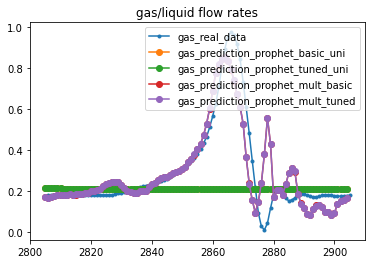

In [20]:
start_ploting = 0
end_ploting = 100
fig,ax = plt.subplots()
ax.set_title('gas/liquid flow rates')
ax.plot(test_mult['ds'].iloc[start_ploting:end_ploting], test_mult['gas(kg/sec)'].iloc[start_ploting:end_ploting], marker=".", label='gas_real_data')
ax.plot(prediction_data_gas_uni_basic['ds'].iloc[start_ploting:end_ploting], prediction_data_gas_uni_basic['yhat'].iloc[start_ploting:end_ploting], marker="o", label='gas_prediction_prophet_basic_uni')
ax.plot(prediction_data_gas_uni_basic['ds'].iloc[start_ploting:end_ploting], prediction_data_gas_uni_basic['yhat'].iloc[start_ploting:end_ploting], marker="o", label='gas_prediction_prophet_tuned_uni')
ax.plot(prediction_data_gas_mult_basic['ds'].iloc[start_ploting:end_ploting], prediction_data_gas_mult_basic['yhat'].iloc[start_ploting:end_ploting], marker="o", label='gas_prediction_prophet_mult_basic')
ax.plot(prediction_data_gas_mult_tuned['ds'].iloc[start_ploting:end_ploting], prediction_data_gas_mult_tuned['yhat'].iloc[start_ploting:end_ploting], marker="o", label='gas_prediction_prophet_mult_tuned')
ax.legend(loc='upper right')
fig.savefig('riser-prophet-results.jpeg')

In [19]:
mse_prophet_gas = pd.DataFrame(\
                               zip(['Prophet Univariate Basic', 'Prophet Univariate Tuned', 'Prophet Multivariate Basic', 'Prophet Multivariate Tuned'], \
                                   np.array([mse_gas_uni_basic,mse_gas_uni_tuned, mse_gas_mult_basic, mse_gas_mult_tuned]).T))
mse_prophet_gas

,0,1
0,Prophet Univariate Basic,0.026237
1,Prophet Univariate Tuned,0.026254
2,Prophet Multivariate Basic,0.003977
3,Prophet Multivariate Tuned,0.003976


## Appendix:
here we are going to tune the univariate model. 

In [ ]:
import itertools
param_grid = {  
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_prior_scale':[0.01, 0.1, 1.0],
    'seasonality_mode': ['multiplicative', 'additive']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics
# Use cross validation to evaluate all parameters
gas_rmse = []
number_iter = 0
# run this for three different 
for params in all_params:
    trainSet_param = train_uni
    number_iter+=1
    trainSet_param = trainSet_param.rename(columns={'gas(kg/sec)':'y'})
    m_gas = Prophet(**params).fit(trainSet_param)  
    df_cv_gas = cross_validation(m_gas,horizon='200 nano', initial='2100 nano', parallel="processes")
    df_p_gas = performance_metrics(df_cv_gas, rolling_window=3)
    gas_rmse.append(df_p_gas['rmse'].values[0])
    print(number_iter)

In [ ]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = gas_rmse
tuning_results[tuning_results['rmse'] < 0.133]